# Vision-RAG - Cohere Embed v4 🤝 Gemini Flash

RAG so far has been mostly done on text. For rich multimedia files like PDFs it often required complex OCR pre-processing steps and dropping relevant graphics from your RAG pipeline.

This notebook shows a pure **vision-based RAG** approach, that even works for complex infographics.

It consists of two components:

*   **Retrieval:** Here we use the state-of-the-art text & image retrieval model [Embed v4](https://cohere.com/blog/embed-4) by Cohere. It allows us to embed and search complex images, like infographics, without any pre-processing.
*   **Vision-LLM:** Here we use [Gemini Flash 2.5](https://deepmind.google/technologies/gemini/flash/) by Google. It allows images & text questions as inputs, and is able to answer questions based on it.




## Setup Cohere for Retrieval

Go to [cohere.com](https://cohere.com) and get an API key. Also install our SDK for easier usage and pdf2image and poppler to convert PDFs to images.

In [ ]:
!pip install -q cohere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.4 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata


In [ ]:
# Create the Cohere API client. Get your API key from cohere.com
import cohere
cohere_api_key = userdata.get('COHERE_API_KEY') #Replace with your Cohere API key
co = cohere.ClientV2(api_key=cohere_api_key)

## Setup Gemini for Generation
Go to the [Google AI Studio](https://aistudio.google.com/apikey) and generate an API Key for Gemini. Gemini also offers a generous free-tier.

Then install the Google GenAI SDK.

In [ ]:
!pip install -q google-genai

In [ ]:
from google import genai
gemini_api_key = userdata.get("GOOGLE_API_KEY")  #Replace with your Gemini API key
client = genai.Client(api_key=gemini_api_key)

In [ ]:
# Wrap long longs in this Notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Image Search

This section will load several infographics from [appeconomyinsights.com](https://www.appeconomyinsights.com/).

For each image we will call [Cohere Embed v4]((https://cohere.com/blog/embed-4) to get an embeddings. This embedding allows us later to perform search to find relevant images for our questions.

In [ ]:
import requests
import os
import io
import base64
import PIL
import tqdm
import time
import numpy as np

In [ ]:
# Some helper functions to resize images and to convert them to base64 format
max_pixels = 1568*1568  #Max resolution for images

# Resize too large images
def resize_image(pil_image):
    org_width, org_height = pil_image.size

    # Resize image if too large
    if org_width * org_height > max_pixels:
        scale_factor = (max_pixels / (org_width * org_height)) ** 0.5
        new_width = int(org_width * scale_factor)
        new_height = int(org_height * scale_factor)
        pil_image.thumbnail((new_width, new_height))

# Convert images to a base64 string before sending it to the API
def base64_from_image(img_path):
    pil_image = PIL.Image.open(img_path)
    img_format = pil_image.format if pil_image.format else "PNG"

    resize_image(pil_image)

    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format=img_format)
        img_buffer.seek(0)
        img_data = f"data:image/{img_format.lower()};base64,"+base64.b64encode(img_buffer.read()).decode("utf-8")

    return img_data



In [ ]:
# Several images from https://www.appeconomyinsights.com/
images = {
    "tesla.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fbef936e6-3efa-43b3-88d7-7ec620cdb33b_2744x1539.png",
    "netflix.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F23bd84c9-5b62-4526-b467-3088e27e4193_2744x1539.png",
    "nike.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa5cd33ba-ae1a-42a8-a254-d85e690d9870_2741x1541.png",
    "google.png": "https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F395dd3b9-b38e-4d1f-91bc-d37b642ee920_2741x1541.png",
    "accenture.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F08b2227c-7dc8-49f7-b3c5-13cab5443ba6_2741x1541.png",
    "tecent.png": "https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0ec8448c-c4d1-4aab-a8e9-2ddebe0c95fd_2741x1541.png"
}

In [ ]:
# Download the images and compute an embedding for each image
img_folder = "img"
os.makedirs(img_folder, exist_ok=True)

img_paths = []
doc_embeddings = []
for name, url in tqdm.tqdm(images.items()):
    img_path = os.path.join(img_folder, name)
    img_paths.append(img_path)

    # Download the image
    if not os.path.exists(img_path):
        response = requests.get(url)
        response.raise_for_status()

        with open(img_path, "wb") as fOut:
            fOut.write(response.content)

    # Get the base64 representation of the image
    api_input_document = {
        "content": [
            {"type": "image", "image": base64_from_image(img_path)},
        ]
    }

    # Call the Embed v4.0 model with the image information
    api_response = co.embed(
        model="embed-v4.0",
        input_type="search_document",
        embedding_types=["float"],
        inputs=[api_input_document],
    )

    # Append the embedding to our doc_embeddings list
    emb = np.asarray(api_response.embeddings.float[0])
    doc_embeddings.append(emb)

doc_embeddings = np.vstack(doc_embeddings)
print("\n\nEmbeddings shape:", doc_embeddings.shape)


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]



Embeddings shape: (6, 1536)


## Vision-RAG

The following shows a simple pipeline for vision-based RAG.

1) We first perform search() - We compute the embedding for the question. We can then use that embedding to search through our prevousily embedded images to find the most relevant image. We return this image.

2) In answer(), we send the question + image to Gemini to give us a final answer to our question

In [ ]:
# Search allows us to find relevant images for a given question using Cohere Embed v4
def search(question, max_img_size=800):
    # Compute the embedding for the query
    api_response = co.embed(
        model="embed-v4.0",
        input_type="search_query",
        embedding_types=["float"],
        texts=[question],
    )

    query_emb = np.asarray(api_response.embeddings.float[0])

    # Compute cosine similarities
    cos_sim_scores = np.dot(query_emb, doc_embeddings.T)

    # Get the most relevant image
    top_idx = np.argmax(cos_sim_scores)

    # Show the images
    print("Question:", question)

    hit_img_path = img_paths[top_idx]

    print("Most relevant image:", hit_img_path)
    image = PIL.Image.open(hit_img_path)
    max_size = (max_img_size, max_img_size)  # Adjust the size as needed
    image.thumbnail(max_size)
    display(image)
    return hit_img_path

# Answer the question based on the information from the image
# Here we use Gemini 2.5 as powerful Vision-LLM
def answer(question, img_path):
    prompt = [f"""Answer the question based on the following image.
Don't use markdown.
Please provide enough context for your answer.

Question: {question}""", PIL.Image.open(img_path)]

    response = client.models.generate_content(
        model="gemini-2.5-flash-preview-04-17",
        contents=prompt
    )

    answer = response.text
    print("LLM Answer:", answer)

Question: What is the net profit for Nike?
Most relevant image: img/nike.png


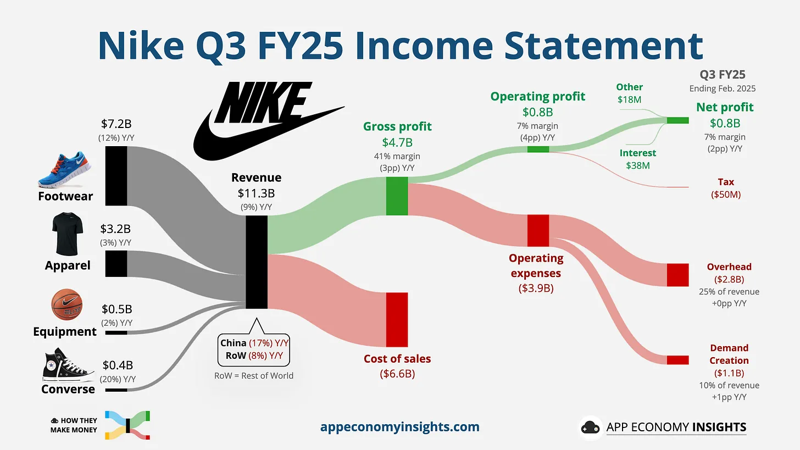

LLM Answer: Based on the Nike Q3 FY25 Income Statement visualization provided, the Net profit for Nike in Q3 FY25, ending February 2025, is $0.8 billion.


In [ ]:
# Define the query
question = "What is the net profit for Nike?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: What are the 3 largest acquisitions from Google?
Most relevant image: img/google.png


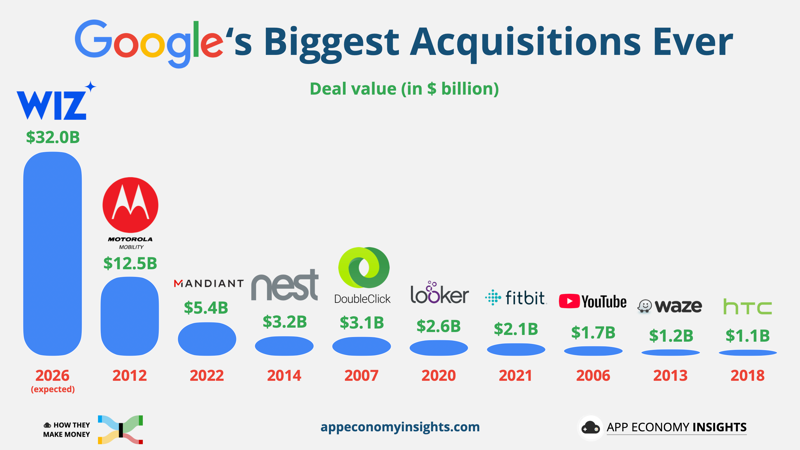

LLM Answer: According to the image titled "Google's Biggest Acquisitions Ever", the 3 largest acquisitions from Google are WIZ at $32.0B, Motorola Mobility at $12.5B, and Mandiant at $5.4B. The image indicates that the WIZ acquisition is expected in 2026, Motorola Mobility was in 2012, and Mandiant was in 2022.


In [ ]:
# Define the query
question = "What are the 3 largest acquisitions from Google?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: What would be the net profit of Tesla without interest?
Most relevant image: img/tesla.png


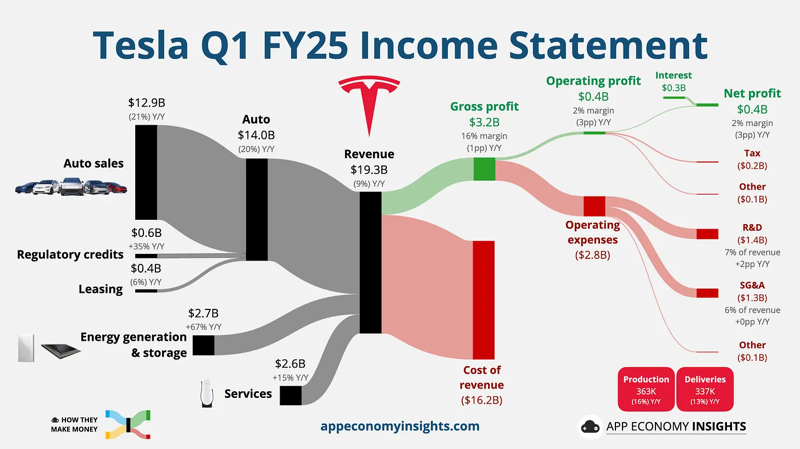

LLM Answer: Based on the image, Tesla's reported Net profit is $0.4B. The diagram shows "Interest $0.3B" as a positive amount that contributes to the final Net profit, alongside the Operating profit. This indicates that the $0.3B is likely net interest income or interest income.

To determine the net profit without this interest income, we subtract the interest amount from the reported net profit.

Net profit (with interest) = $0.4B
Interest = $0.3B

Net profit without interest = Net profit (with interest) - Interest
Net profit without interest = $0.4B - $0.3B = $0.1B.

Therefore, the net profit of Tesla without interest would be $0.1B.


In [ ]:
# Define the query
question = "What would be the net profit of Tesla without interest?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: Is GenAI a good business for consulting companies?
Most relevant image: img/accenture.png


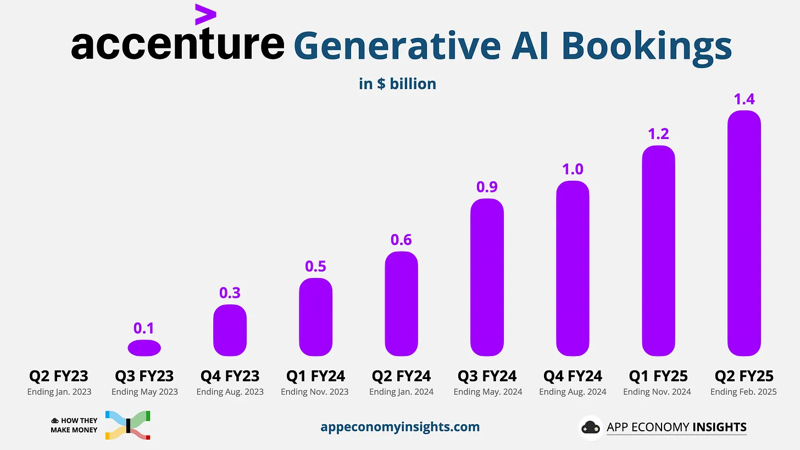

LLM Answer: Based on the image showing Accenture's Generative AI bookings, the trend indicates that Generative AI is a growing and potentially good business for consulting companies like Accenture. The bookings have consistently increased from $0.1 billion in Q2 FY23 (ending Jan. 2023) to $1.4 billion in Q2 FY25 (ending Feb. 2025). This substantial growth in bookings over a relatively short period suggests strong demand for GenAI-related services from clients, indicating a positive business outlook for consulting firms in this area.


In [ ]:
# Define the query
question = "Is GenAI a good business for consulting companies?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: In which region does Netflix generate the highest revenue?
Most relevant image: img/netflix.png


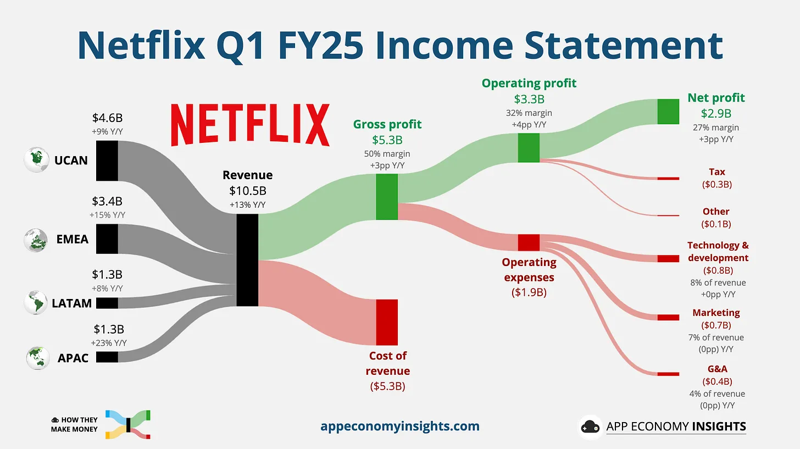

LLM Answer: Based on the Netflix Q1 FY25 Income Statement image, the revenue breakdown by region is as follows: UCAN generated $4.6 billion, EMEA generated $3.4 billion, LATAM generated $1.3 billion, and APAC generated $1.3 billion. Comparing these amounts, Netflix generates the highest revenue in the UCAN region with $4.6 billion.


In [ ]:
# Define the query
question = "In which region does Netflix generate the highest revenue?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: How much could tecent grow their revenue year-over-year for the last 5 years?
Most relevant image: img/tecent.png


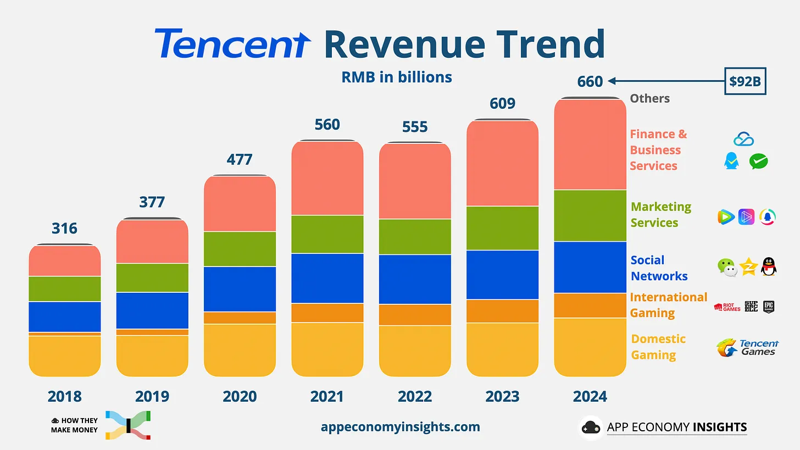

LLM Answer: Based on the image titled "Tencent Revenue Trend", which shows revenue in RMB billions from 2018 to 2024, we can calculate the year-over-year revenue growth for the last 5 years, covering the period from 2020 to 2024.

Tencent's revenue was:
- 377 billion RMB in 2019
- 477 billion RMB in 2020
- 560 billion RMB in 2021
- 555 billion RMB in 2022
- 609 billion RMB in 2023
- 660 billion RMB in 2024 (projected)

The year-over-year revenue growth rates were:
- In 2020, revenue grew from 377 billion RMB to 477 billion RMB, which is a growth of approximately ((477 - 377) / 377) * 100% = 26.5%.
- In 2021, revenue grew from 477 billion RMB to 560 billion RMB, which is a growth of approximately ((560 - 477) / 477) * 100% = 17.4%.
- In 2022, revenue decreased slightly from 560 billion RMB to 555 billion RMB, which is a growth of approximately ((555 - 560) / 560) * 100% = -0.9%.
- In 2023, revenue grew from 555 billion RMB to 609 billion RMB, which is a growth of approximately ((609 - 5

In [ ]:
# Define the query
question = "How much could tecent grow their revenue year-over-year for the last 5 years?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

# Vision-RAG - ColPali 🤝 Gemini Flash

In [ ]:
!pip install byaldi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.7 [186 kB]
Fetched 186 kB in 1s (146 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 126333 

In [ ]:
import base64
import os
os.environ["HF_TOKEN"] = ""#userdata.get('HF_TOKEN') # to download the ColPali model
from byaldi import RAGMultiModalModel

In [ ]:
RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2", verbose=1)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [ ]:
RAG.index(
    input_path="./img/",
    index_name="attention",
    store_collection_with_index=True,
    overwrite=True
)

Indexing file: img/netflix.png
Added page 1 of document 0 to index.
Index exported to .byaldi/attention
Indexing file: img/google.png
Added page 1 of document 1 to index.
Index exported to .byaldi/attention
Indexing file: img/tecent.png
Added page 1 of document 2 to index.
Index exported to .byaldi/attention
Indexing file: img/nike.png
Added page 1 of document 3 to index.
Index exported to .byaldi/attention
Indexing file: img/tesla.png
Added page 1 of document 4 to index.
Index exported to .byaldi/attention
Indexing file: img/accenture.png
Added page 1 of document 5 to index.
Index exported to .byaldi/attention
Index exported to .byaldi/attention


{0: 'img/netflix.png',
 1: 'img/google.png',
 2: 'img/tecent.png',
 3: 'img/nike.png',
 4: 'img/tesla.png',
 5: 'img/accenture.png'}

In [ ]:
from IPython.display import display
from PIL import Image
import io

In [ ]:
question = "What is the net profit for Nike?"

In [ ]:
results = RAG.search(question, k=1)

In [ ]:
results

[{'doc_id': 3, 'page_num': 1, 'score': 15.1875, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAABbAAAAMzCAIAAAD4TqOgAAEAAElEQVR4nOydd7ylVXX3f2vt/ZRTb50+w9BBsGHvMbYYNfYSxRSNsbfY8tqNisYSO2qiqNjFAmIBVMQuvaMgHQamz22nPGXvtd4/nnPOvTMMMCgWnP39PB+4c+8pT9n1txotLCwgEAgEAoFAIBAIBAKBQGBvgv/cJxAIBAKBQCAQCAQCgUAg8KcmCCKBQCAQCAQCgUAgEAgE9jqCIBIIBAKBQCAQCAQCgUBgryMIIoFAIBAIBAKBQCAQCAT2OoIgEggEAoFAIBAIBAKBQGCvIwgigUAgEAgEAoFAIBAIBPY6giASCAQCgUAgEAgEAoFAYK8jCCKBQCAQCAQCgUAgEAgE9jqCIBIIBAKBQCAQCAQCgUBgryMIIoFAIBAIBAKBQCAQCAT2OoIgEggEAoFAIBAIBAKBQGCvIwgigUAgEAgEAoFAIBAIBPY6giASCAQCgUAgEAgEAoFAYK8jCCKBQCAQCAQCgUAgEAgE9jqCIBIIBAKBQCAQCAQCgUBgryMIIoFAIBAIBAKBQCAQCAT2OoIgEggEAoFAIBAIBAKBQGCvIwgigUAgEAgEAoFAIBAIBPY6giASCAQCgUAgEAgEAoFAYK8jCCKBQCAQCAQCgUAgEAgE9jqCIBIIBAKBQCAQCAQCgUBgryMIIoFAIBAIBAKBQCAQCAT2OoIgEggEAoFAIBAIBAKBQGCvIwgigUAgEAgEAoFAIBAIBPY6giASCAQCgUAgEAgEAoFAYK8jCCKBQCAQCAQCgUAgEAgE9jqCIBIIBAKBQCAQCAQCgUBgryMIIoFAIBAIBAKBQCAQCAT2OoIgEggEAoFAIBAIBAKBQGCvIwgigUAgEAgEAoFAIBAIBPY6giASCAQCgUAgEAgEA

In [ ]:
image_bytes = base64.b64decode(results[0].base64)

In [ ]:
def show_results(question):
  results = RAG.search(question, k=1)
  image_bytes = base64.b64decode(results[0].base64)
  # Convert bytes to image using Pillow
  image = Image.open(io.BytesIO(image_bytes))

  # Display the image
  display(image)

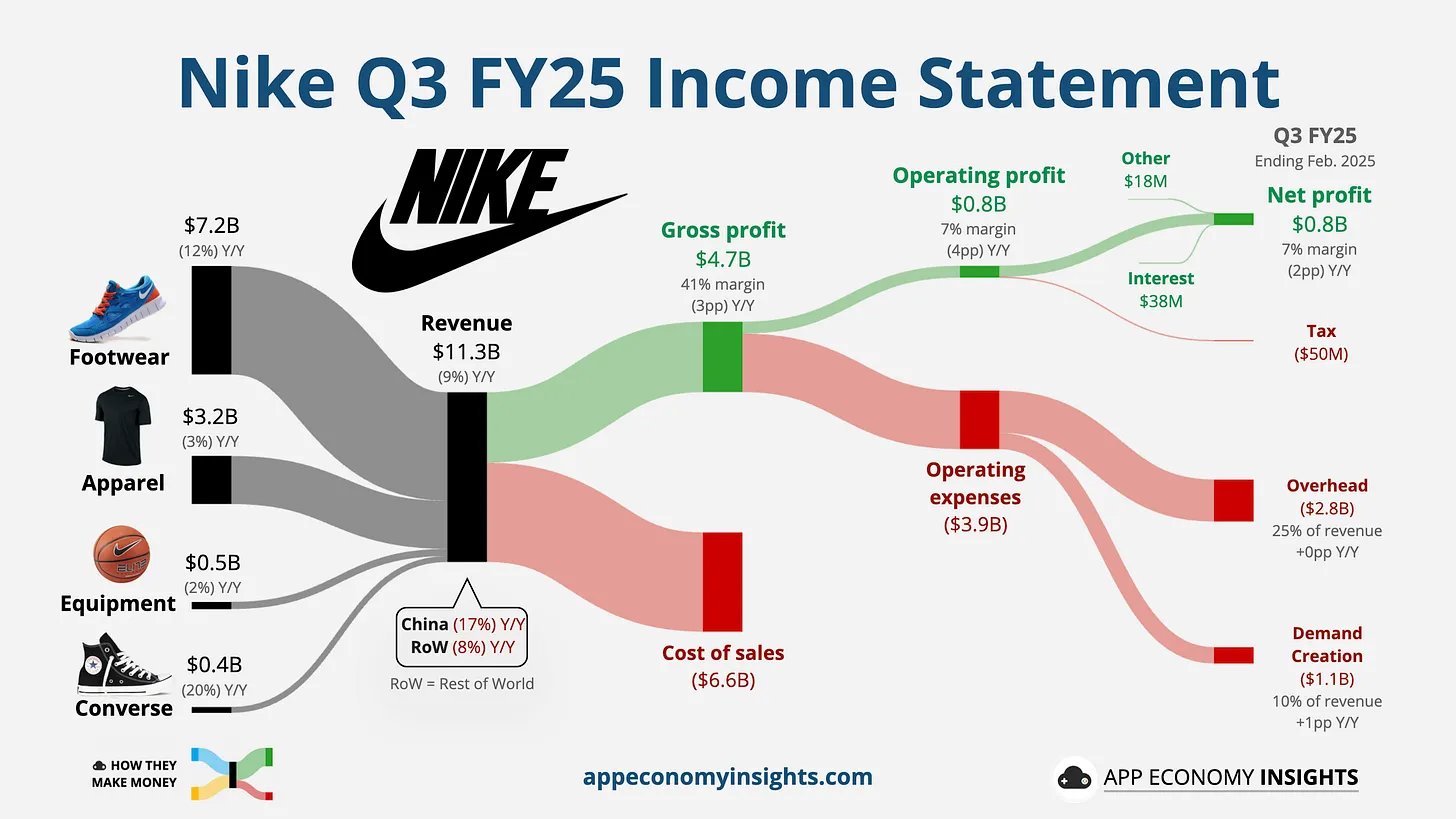

In [ ]:
show_results(question)

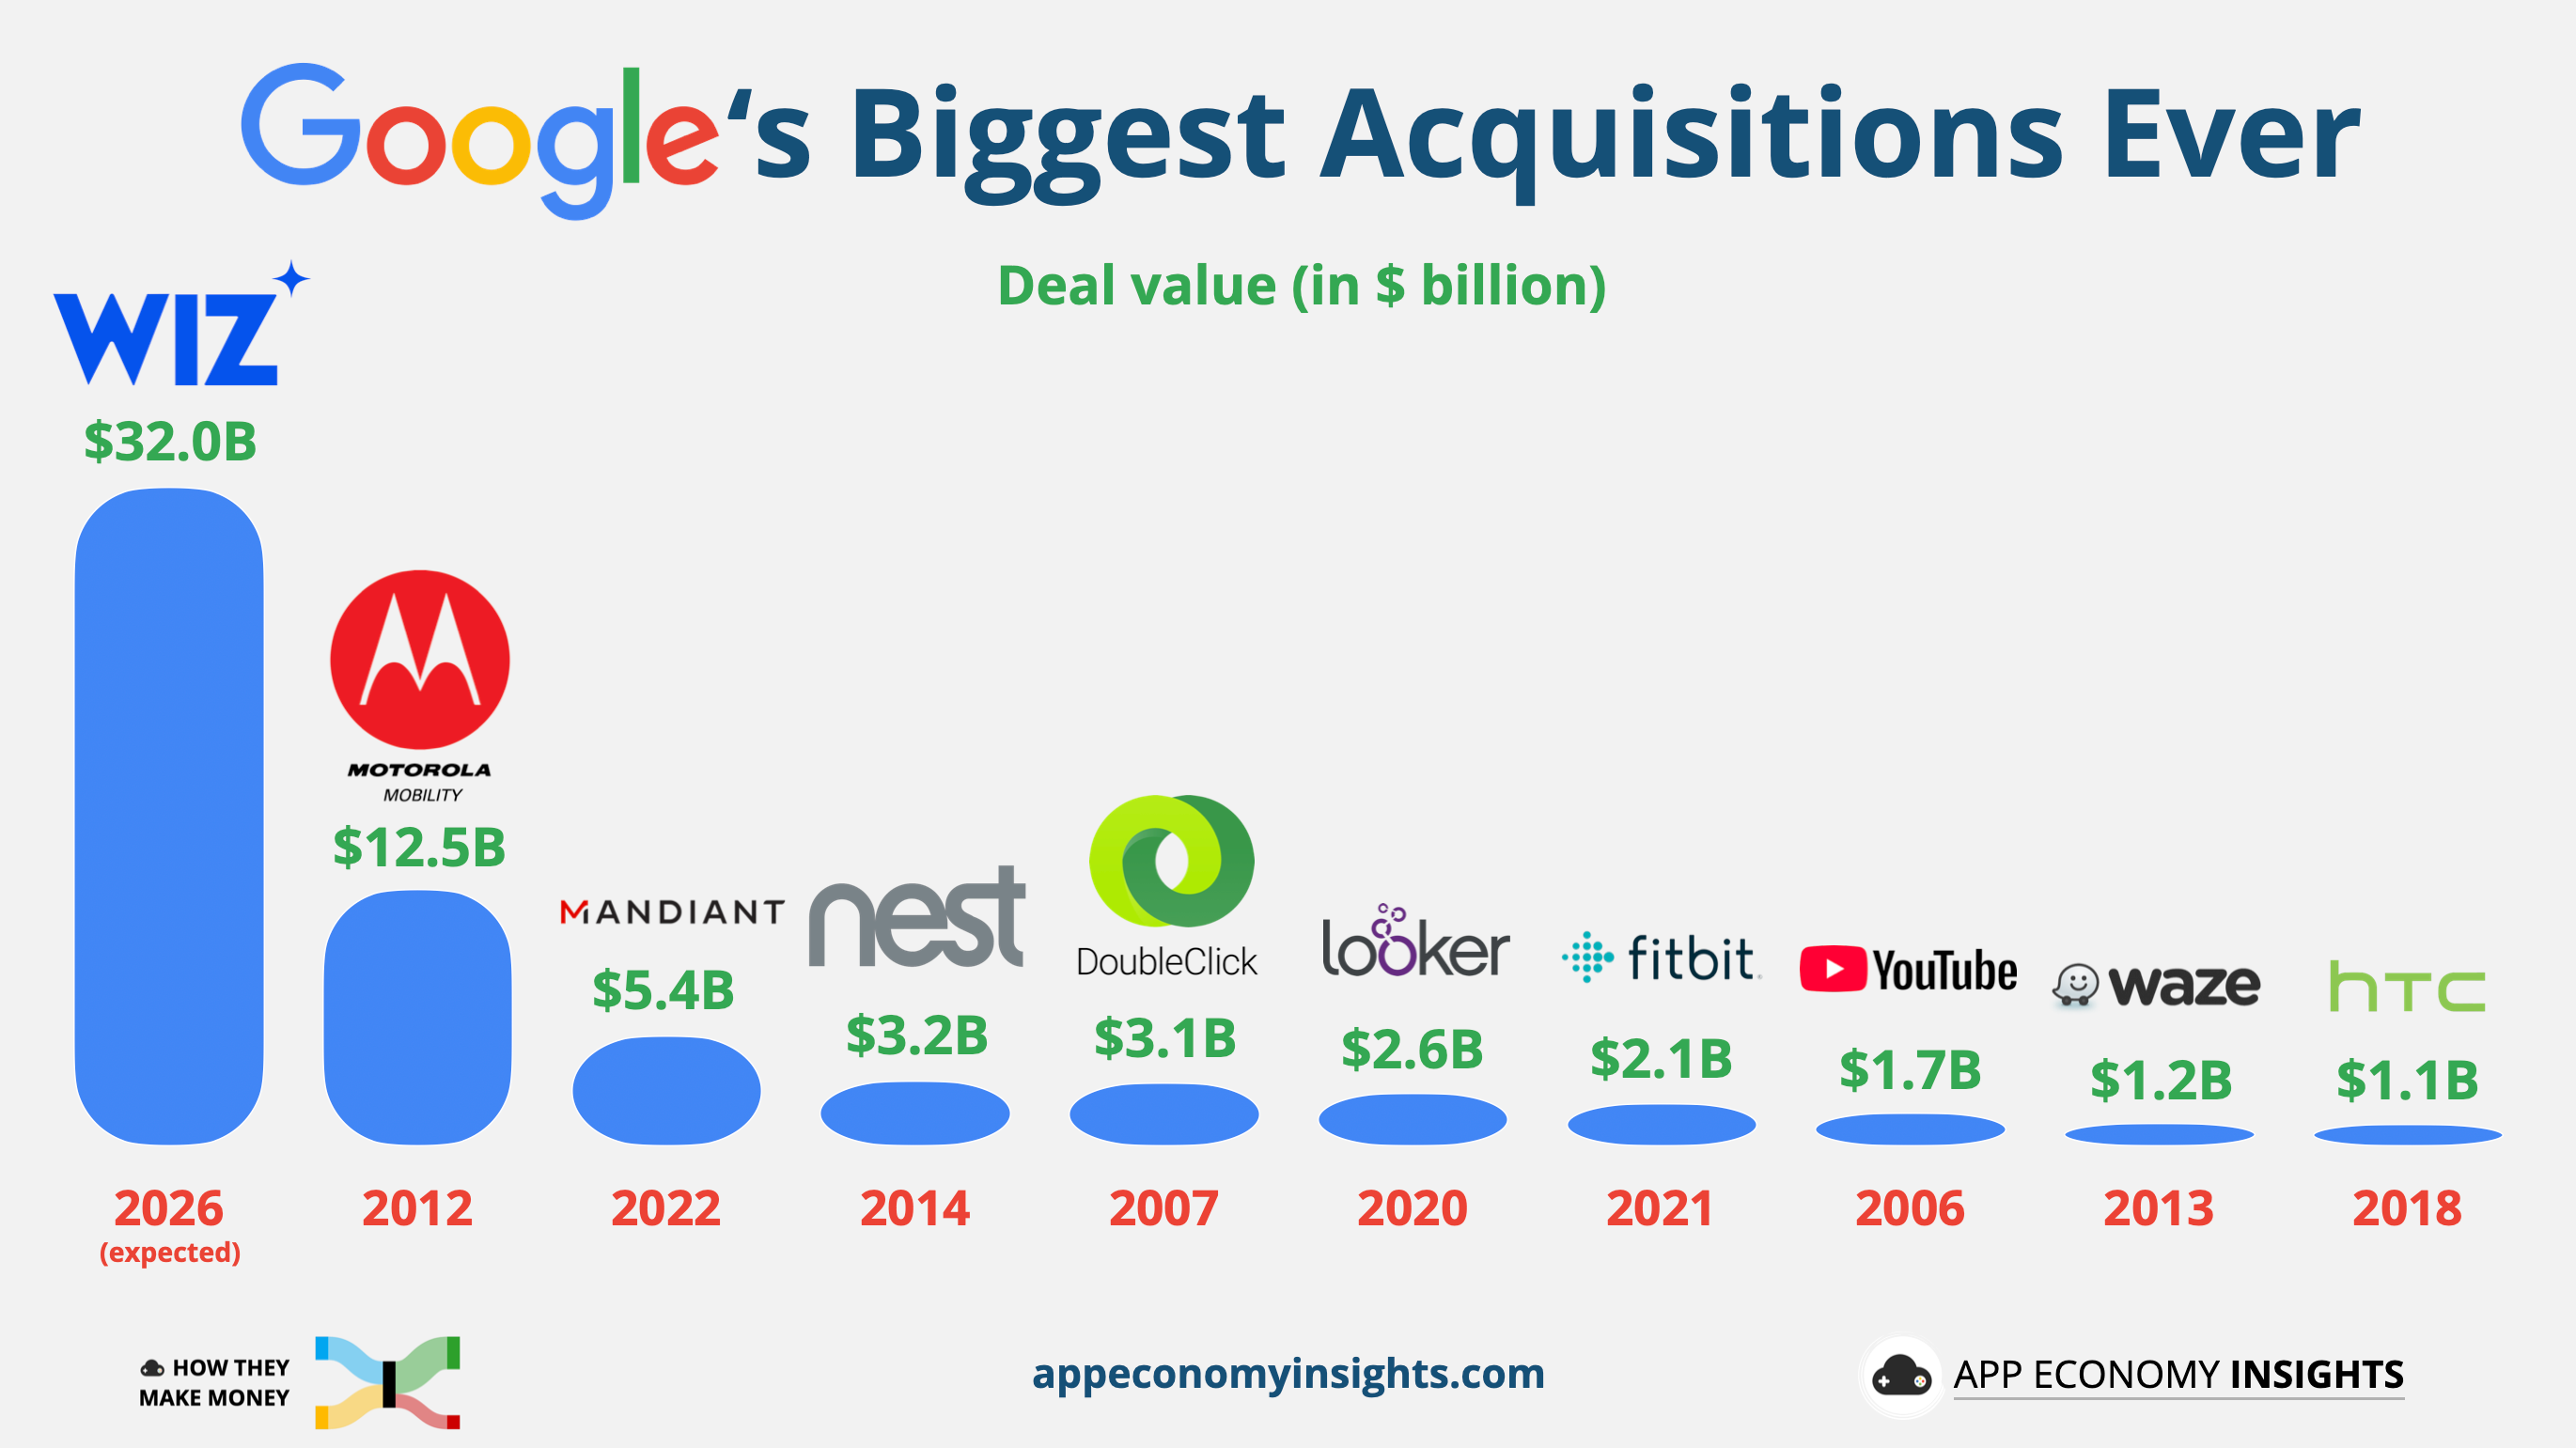

In [ ]:
# Define the query
question = "What are the 3 largest acquisitions from Google?"
show_results(question)

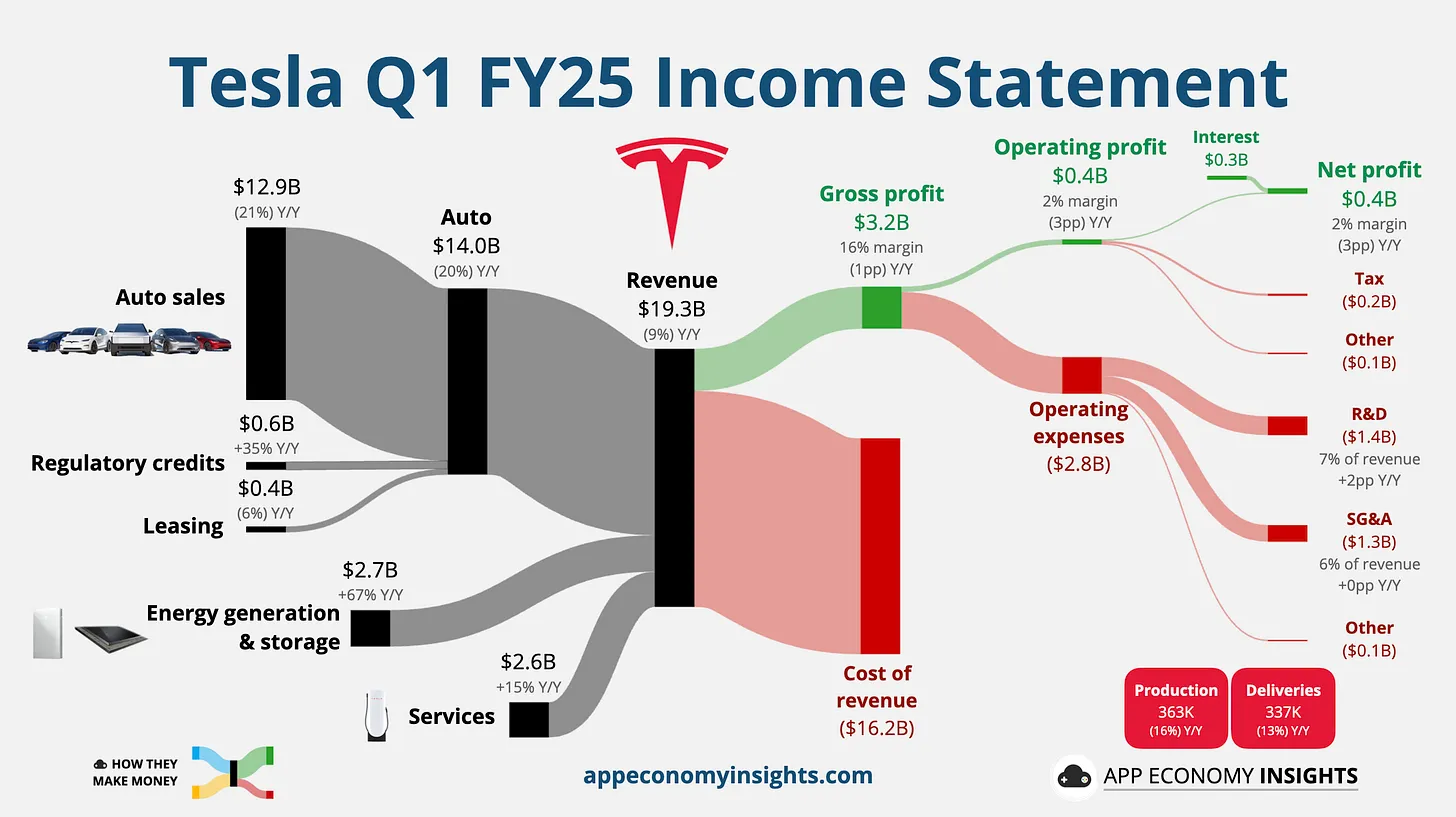

In [ ]:
# Define the query
question = "What would be the net profit of Tesla without interest?"
show_results(question)

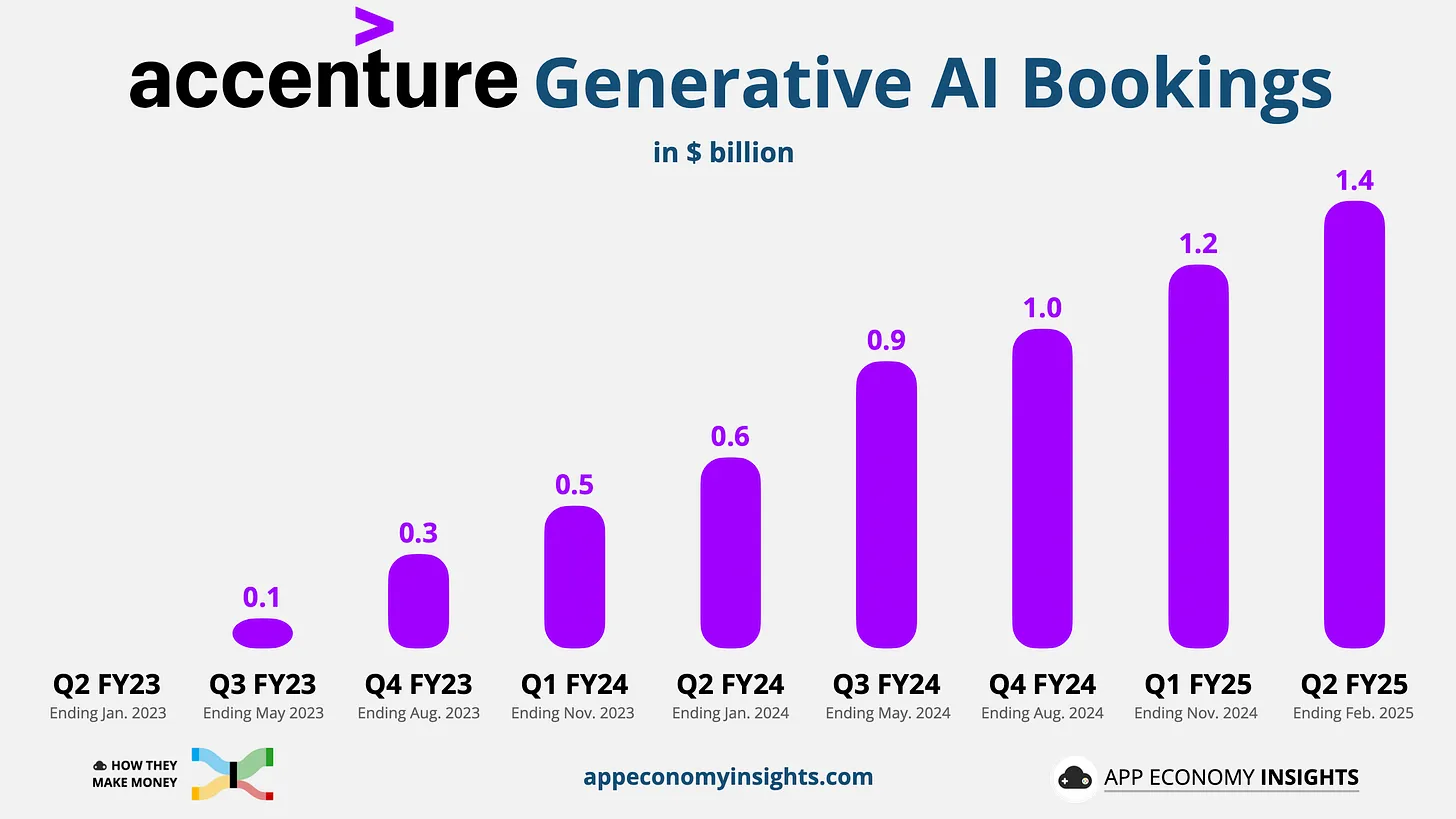

In [ ]:
question = "Is GenAI a good business for consulting companies?"
show_results(question)